In [81]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from metadata.etfs import etfs_large, etfs_small

warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [82]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl

def calculateRollingSharpeRatio(dfPnl, window = 3, annulaize = 12, rf = 0):
    rolling_mean = (dfPnl.rolling(window=window).mean() - rf) 
    rolling_std = dfPnl.rolling(window=window).std()

    # replace zeros with NaNs
    rolling_std = rolling_std.replace(0, np.nan)

    rolling_sr = rolling_mean / rolling_std * np.sqrt(annulaize)

    return rolling_sr

def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateExpectedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

def calculateVolatility(dfPnl, annualize = 12):
    v = dfPnl.std() * annualize * 100
    return v

def calculateSortino(dfPnl, annualize = 12):
    
    # portfolio downside vol
    downside_rets = dfPnl.copy()
    downside_rets[downside_rets >= 0] = np.nan
    downside_vol = downside_rets[~pd.isna(downside_rets)].std()

    # portfolio sharpe
    sortino_ratio = (dfPnl.mean() / downside_vol) * annualize

    return sortino_ratio

def calculateAvgDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    avg_drawdown = drawdown.mean() * 100

    return avg_drawdown

def calculateMaxDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    max_drawdown = drawdown.min() * 100

    return max_drawdown

In [83]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_funcs = {
    "E[Rt]": calculateExpectedReturn,
    "Volatility": calculateVolatility,
    "Sharpe": calculateSharpeRatio,
    "Sortino": calculateSortino,
    "AvgDD": calculateAvgDD,
    "MaxDD": calculateMaxDD,    
}
# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]

In [84]:
all_pnl = []
all_measures = []
for etf in etfs_large:
    for i, fs in enumerate(fs_methods):
        files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))

        if len(files) != 1:
            raise ValueError(f"Found {len(files)} files for {etf} and {fs}.")

        for f in files:
            dfPred = load_pickle(f)["predictions"]
            # dfPred = np.log(1 + dfPred / 100)
            
            # run backtest
            bt = backtester(dfPred)
            bt.simpleStrategy()

                # extract pnl
            if i == 0:
                dfPnl = dfPred[["true"]].copy()
                dfPnl.columns = [etf]
            dfPnl[fs] = bt.pnl
    
    # save pnl
    melt_dfPnl = dfPnl.reset_index().melt("date")
    melt_dfPnl["etf"] = etf
    all_pnl.append(melt_dfPnl)

    # calculate measures
    measures = []
    for tag, performance_measure in metric_funcs.items():
        measure = performance_measure(dfPnl)
        measures.append(pd.DataFrame(measure, columns=[tag]))

    measures_df = pd.concat(measures, axis=1)
    melt_measures_df = measures_df.reset_index().melt("index")
    melt_measures_df["etf"] = etf
    all_measures.append(melt_measures_df)

all_measures_df = pd.concat(all_measures)
all_pnl_df = pd.concat(all_pnl)

### Plot Correlation Matrices

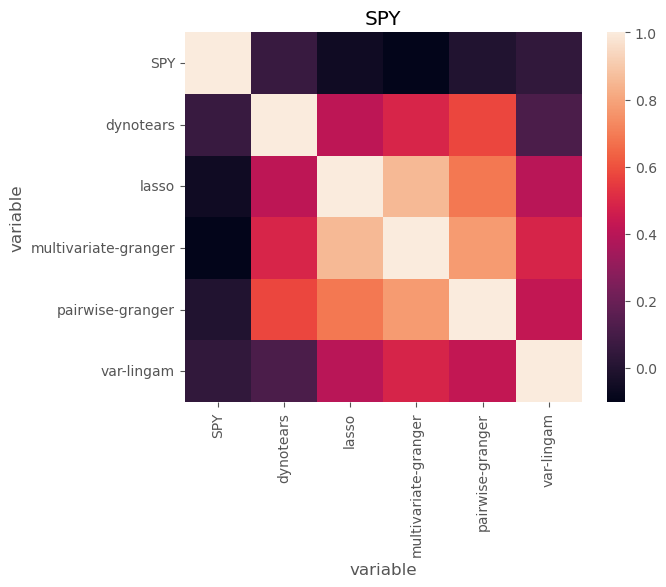

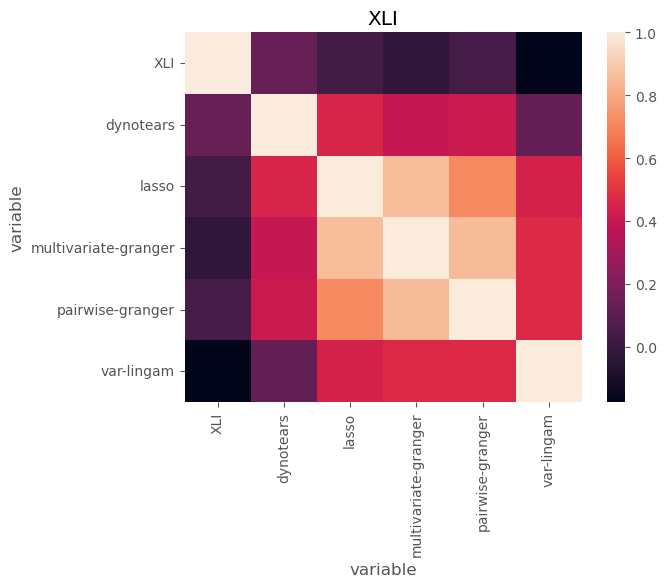

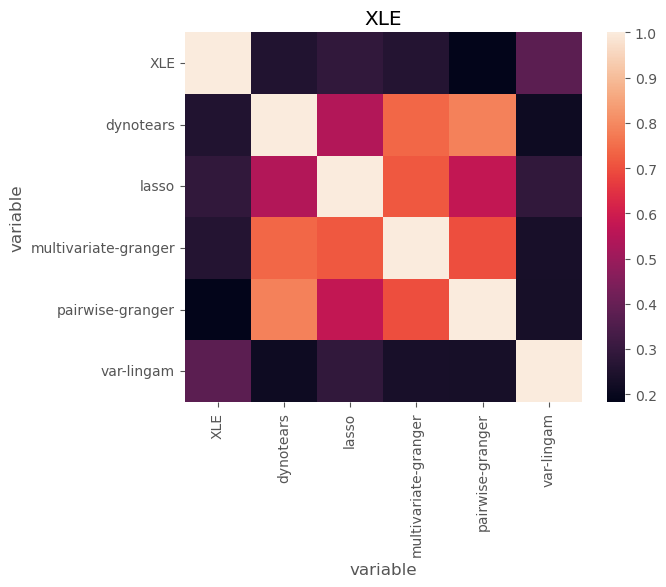

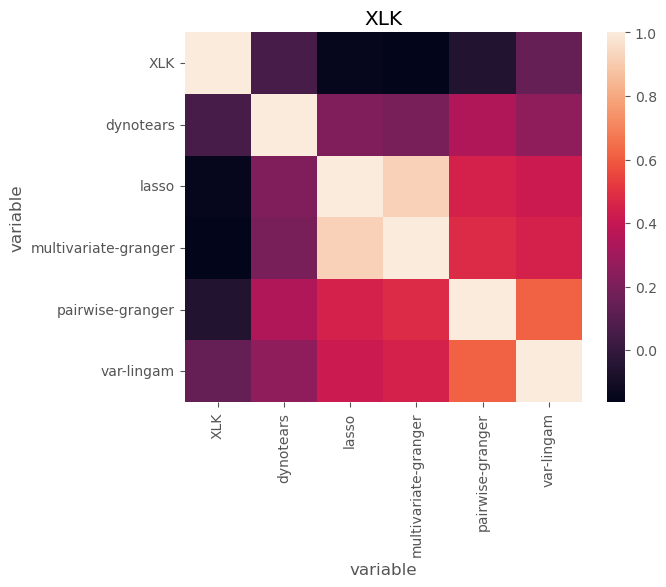

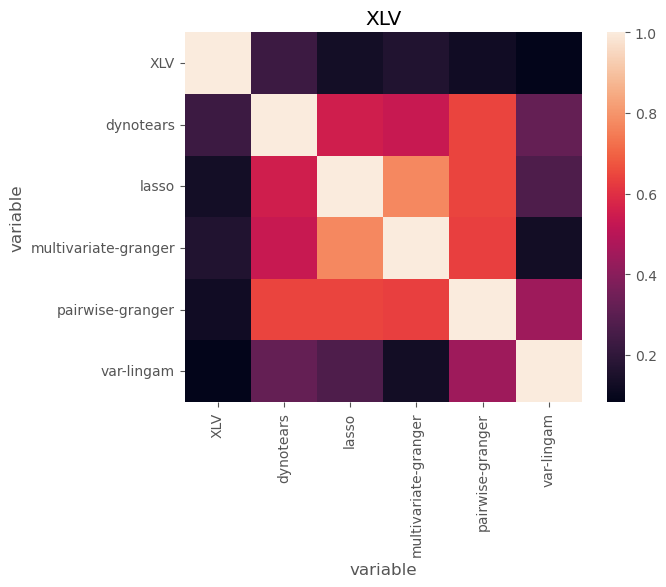

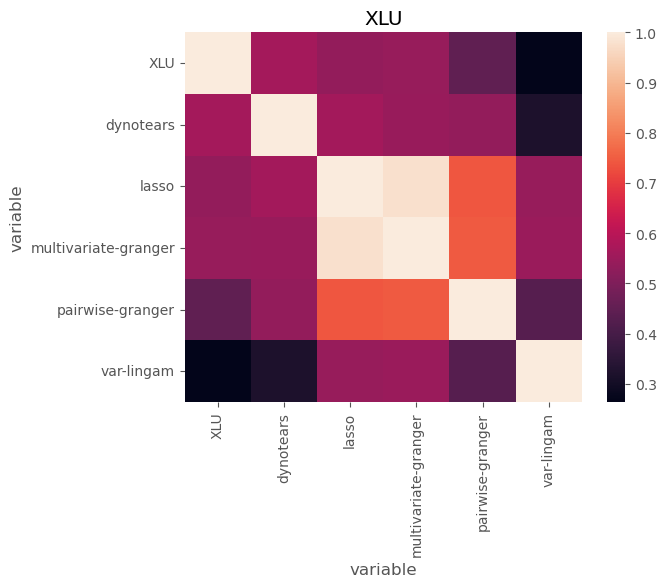

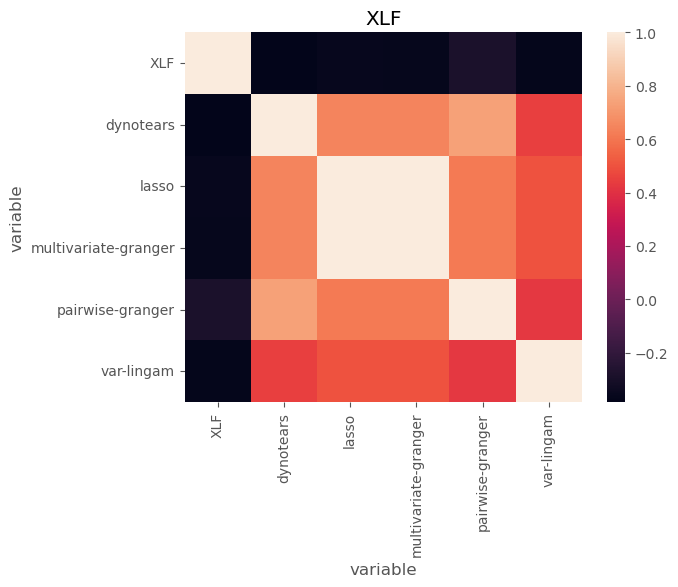

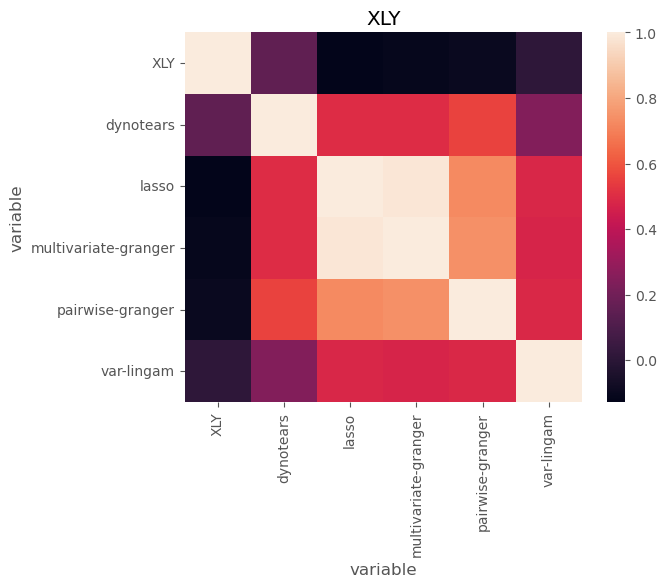

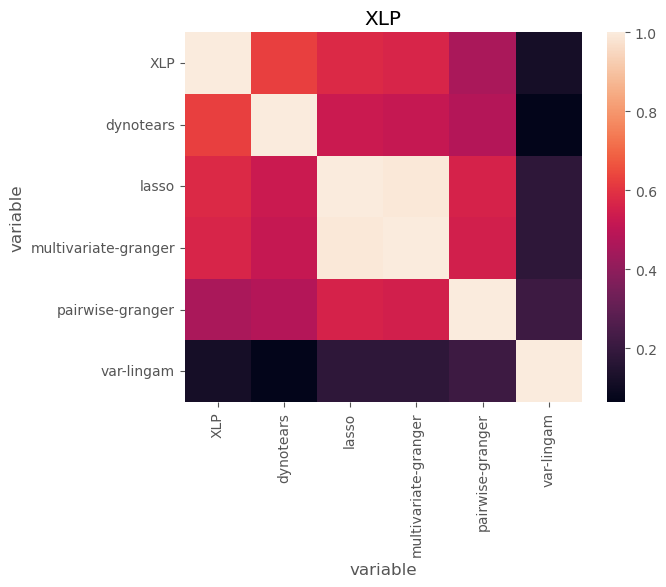

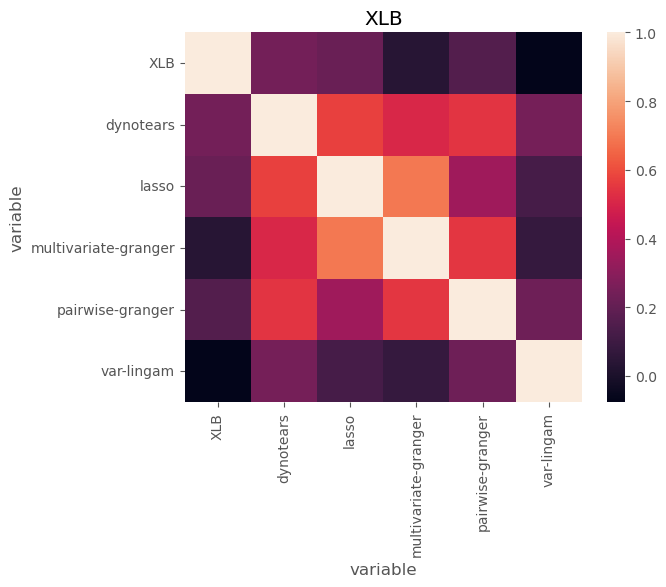

In [85]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    corr = tmp_dfPnl.corr()

    sns.heatmap(corr)
    plt.title(target)
    plt.show()

### Boxplot Portfolio Metrics

In [102]:
for measure in all_measures_df["variable"].unique():
    boxplot_df = all_measures_df.loc[(all_measures_df["variable"] == measure)&
                                     (~all_measures_df["index"].isin(etfs_large))].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="index", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(measure, fontsize=20)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{measure}_fs.png'))

KeyError: 'variable'

### Plot Cumulative Returns

In [87]:
tmp_dfPnl

variable         XLB  dynotears     lasso  multivariate-granger  \
date                                                              
2004-01-31 -0.045218   0.045218 -0.045218             -0.045218   
2004-02-29  0.050822   0.050822  0.050822              0.050822   
2004-03-31 -0.023408   0.023408 -0.023408             -0.023408   
2004-04-30 -0.047413  -0.047413  0.047413              0.047413   
2004-05-31  0.027703   0.027703  0.027703              0.027703   
...              ...        ...       ...                   ...   
2022-07-31  0.059729   0.059729  0.059729             -0.059729   
2022-08-31 -0.035434  -0.035434  0.035434              0.035434   
2022-09-30 -0.097277  -0.097277 -0.097277             -0.097277   
2022-10-31  0.085491   0.085491  0.085491              0.085491   
2022-11-30  0.110679   0.110679 -0.110679              0.110679   

variable    pairwise-granger  var-lingam  
date                                      
2004-01-31         -0.045218    0.045218  
2004-02-29          0.050822    0.050822  
2004-03-31         -0.023408    0.023408  
2004-04-30         -0.047413    0.047413  
2004-05-31         -0.027703    0.027703  
...                      ...         ...  
2022-07-31         -0.059729    0.000000  
2022-08-31         -0.035434   -0.000000  
2022-09-30         -0.097277   -0.000000  
2022-10-31          0.085491    0.000000  
2022-11-30          0.110679    0.000000  

[227 rows x 6 columns]

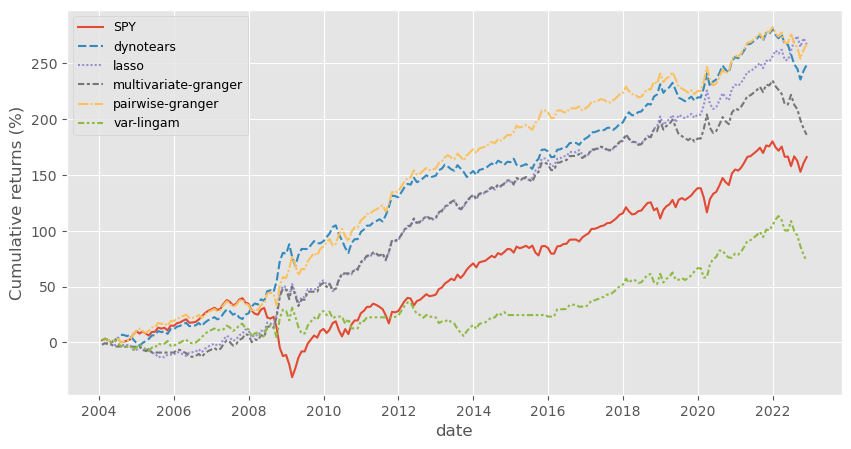

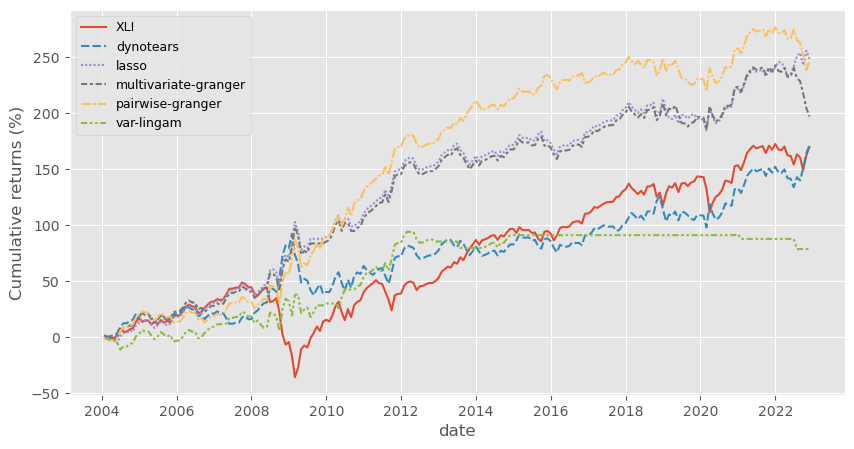

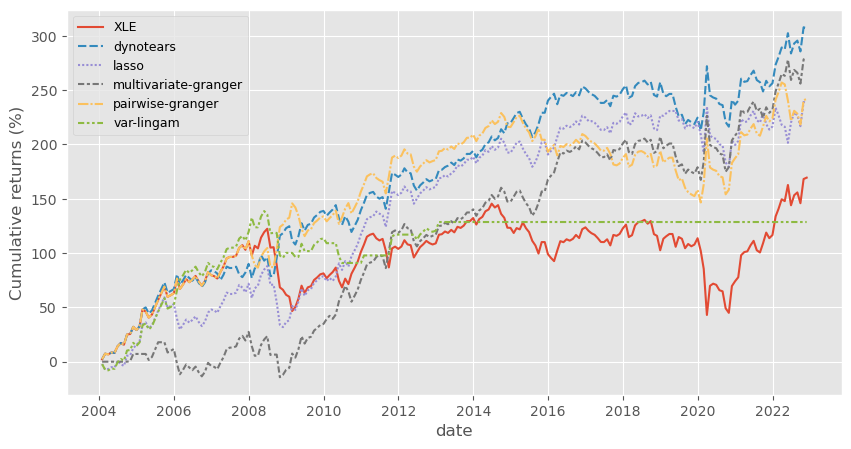

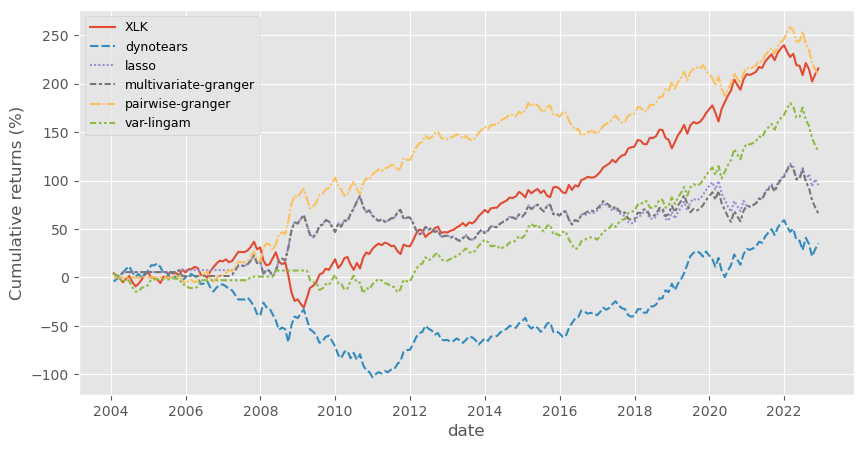

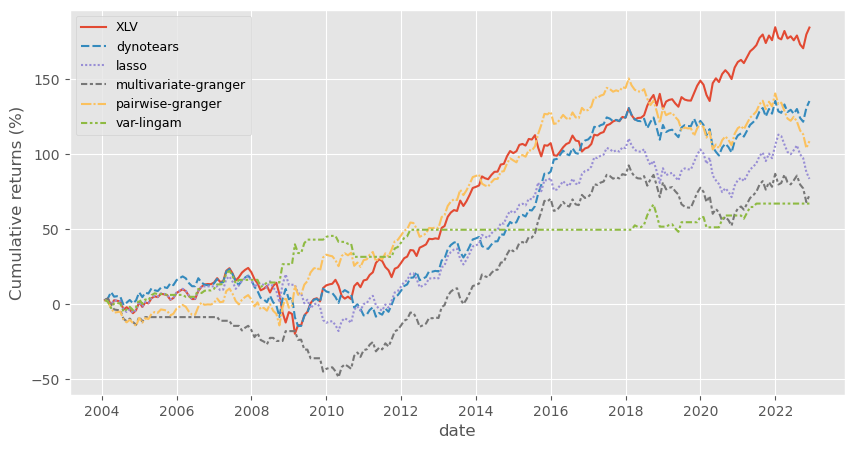

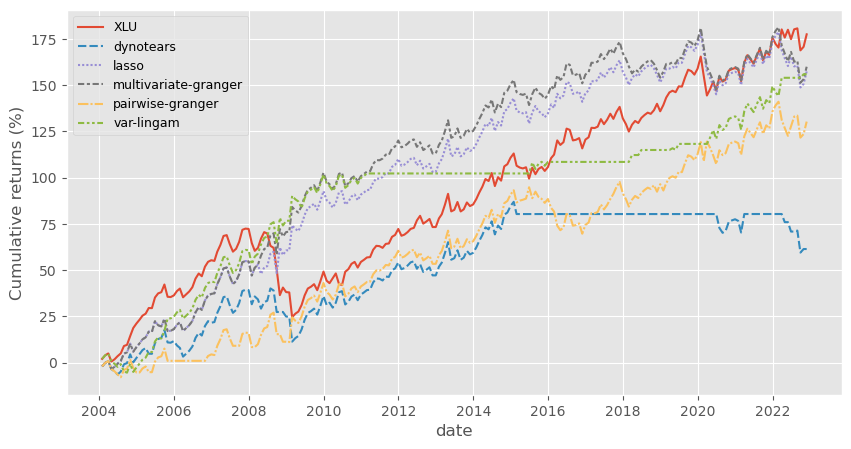

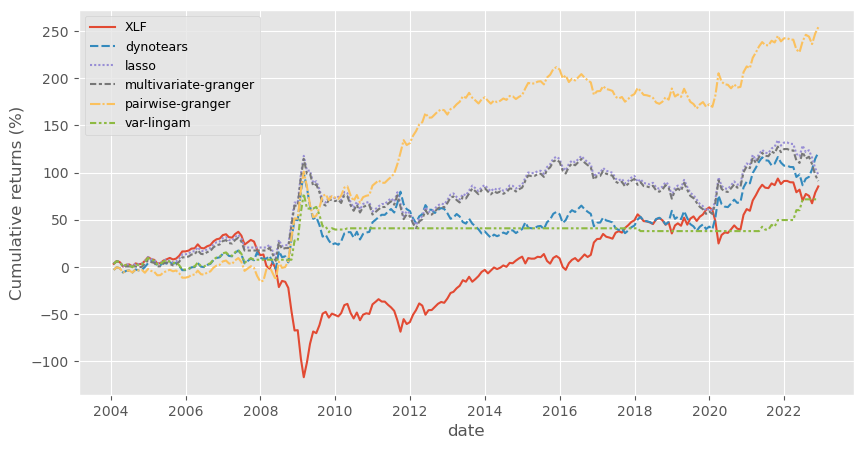

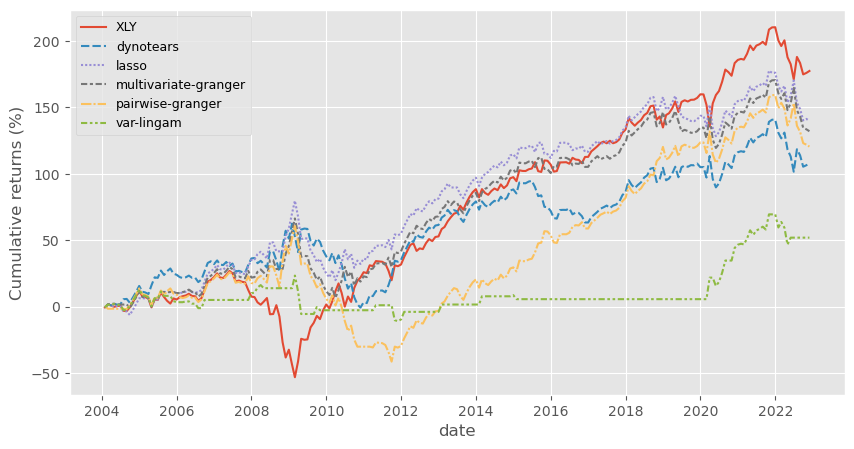

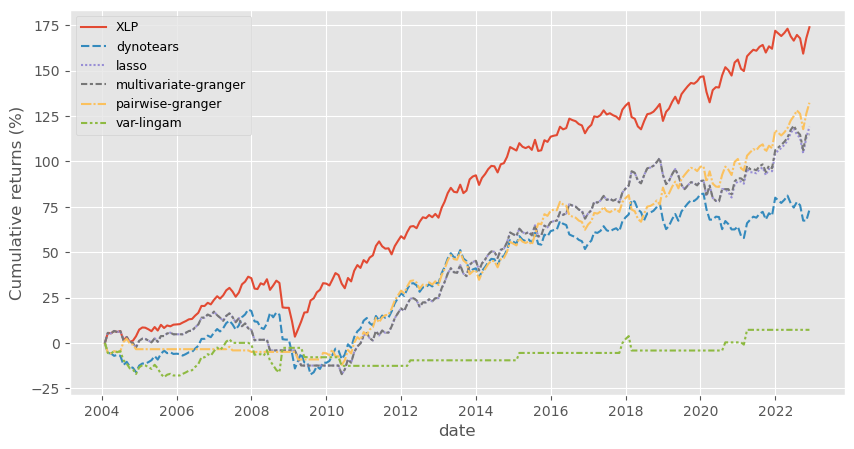

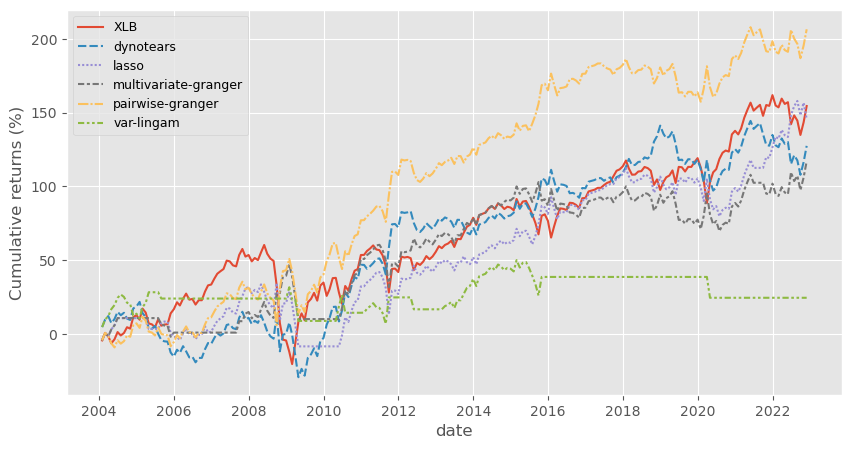

In [88]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()
    tmp_dfPnl.columns.name = ""
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    sns.lineplot(data = tmp_dfPnl.cumsum() * 100, ax = ax)
    ax.set_ylabel("Cumulative returns (%)")
    # ax.set_title(target)
    ax.legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret.png"))

### Plot Rolling Sharpe Ratios

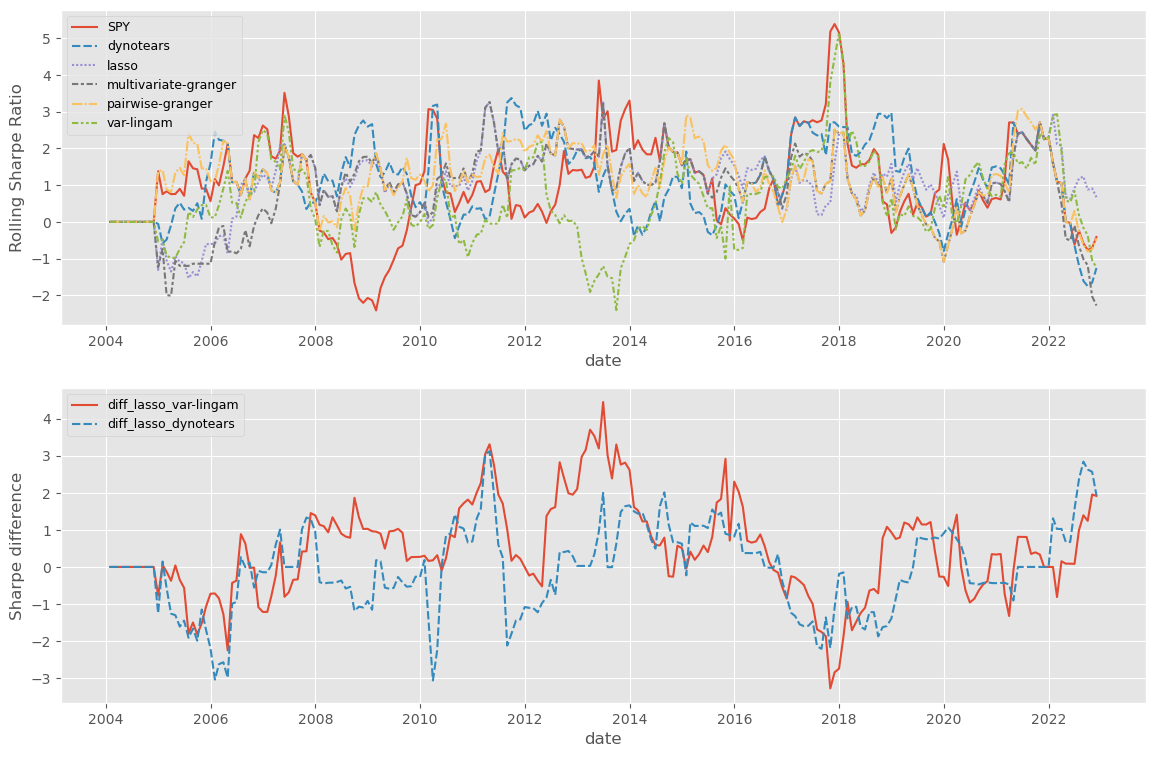

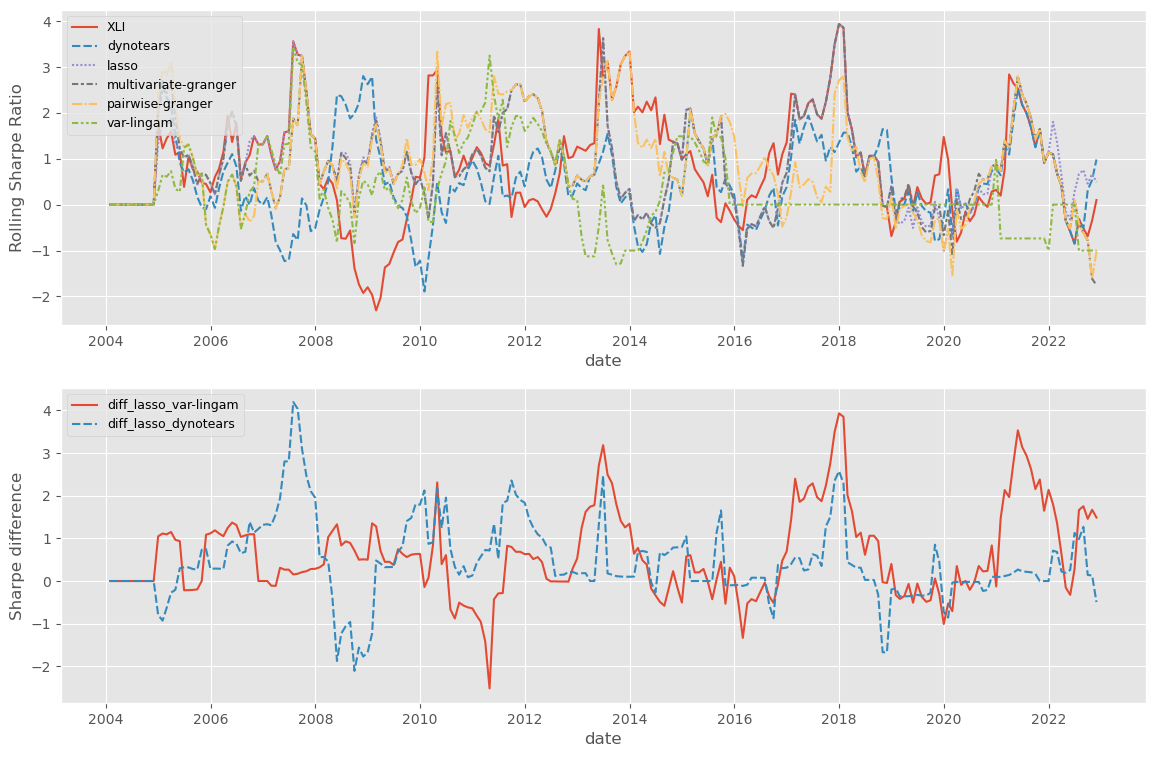

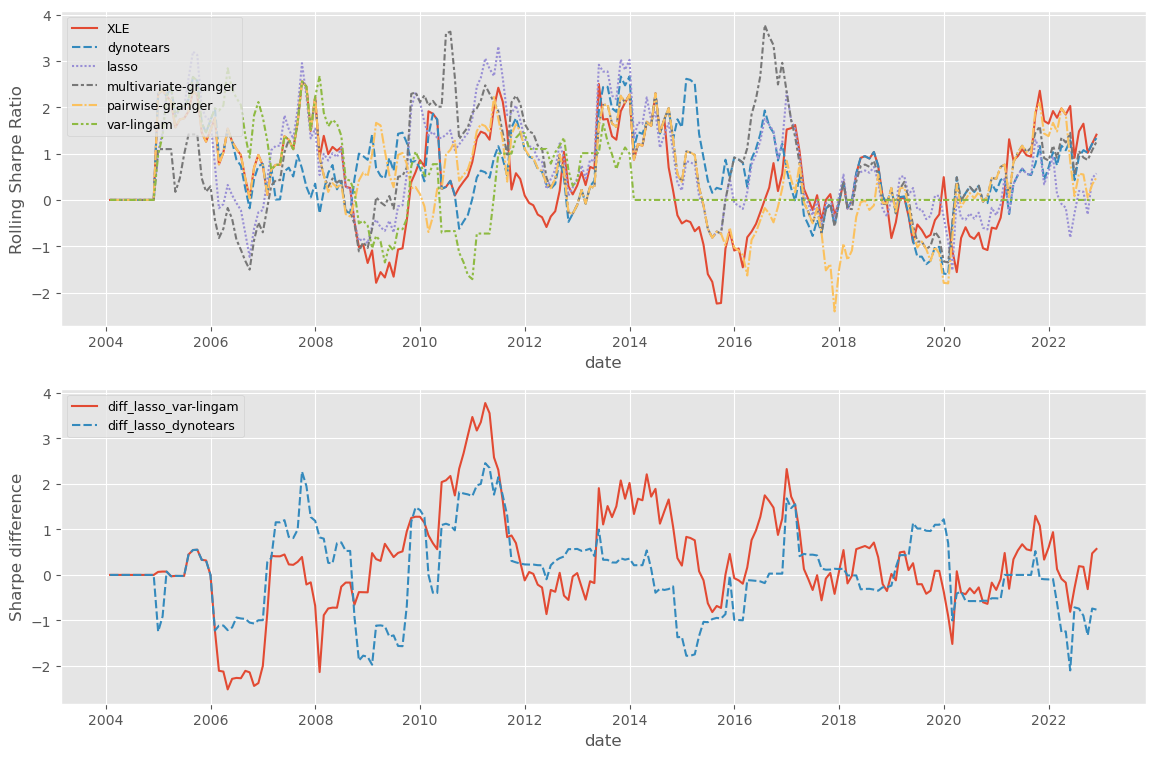

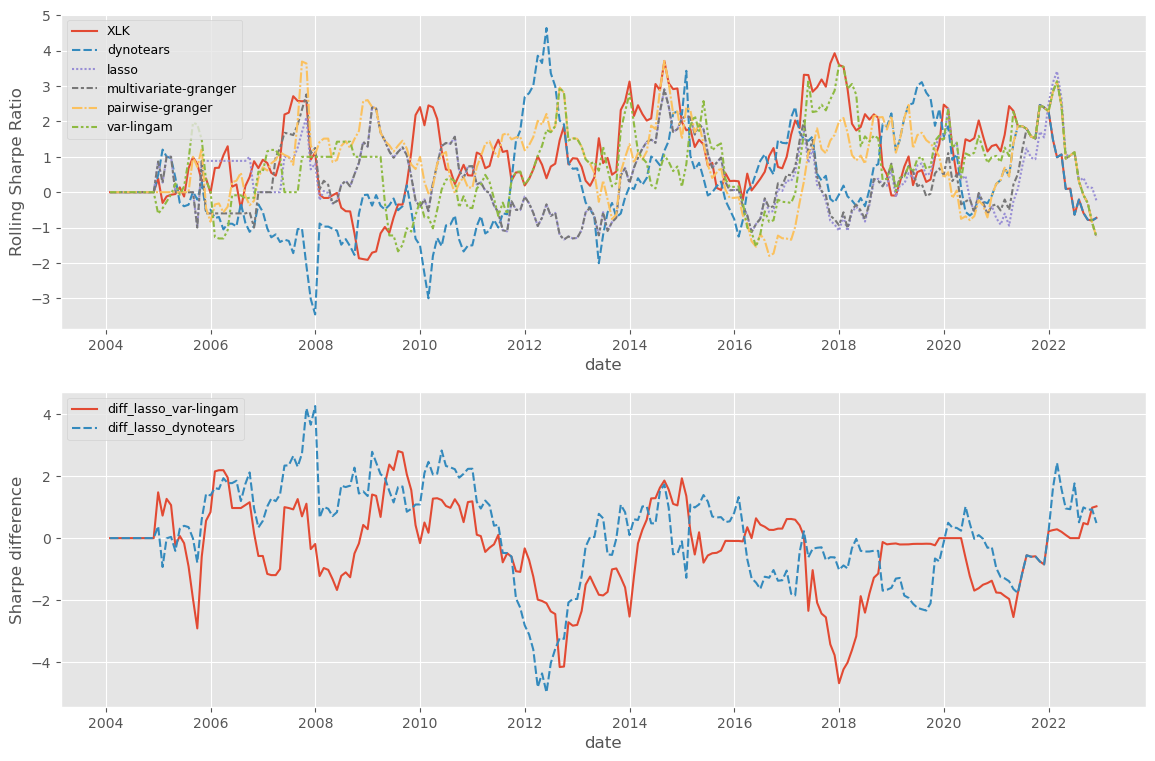

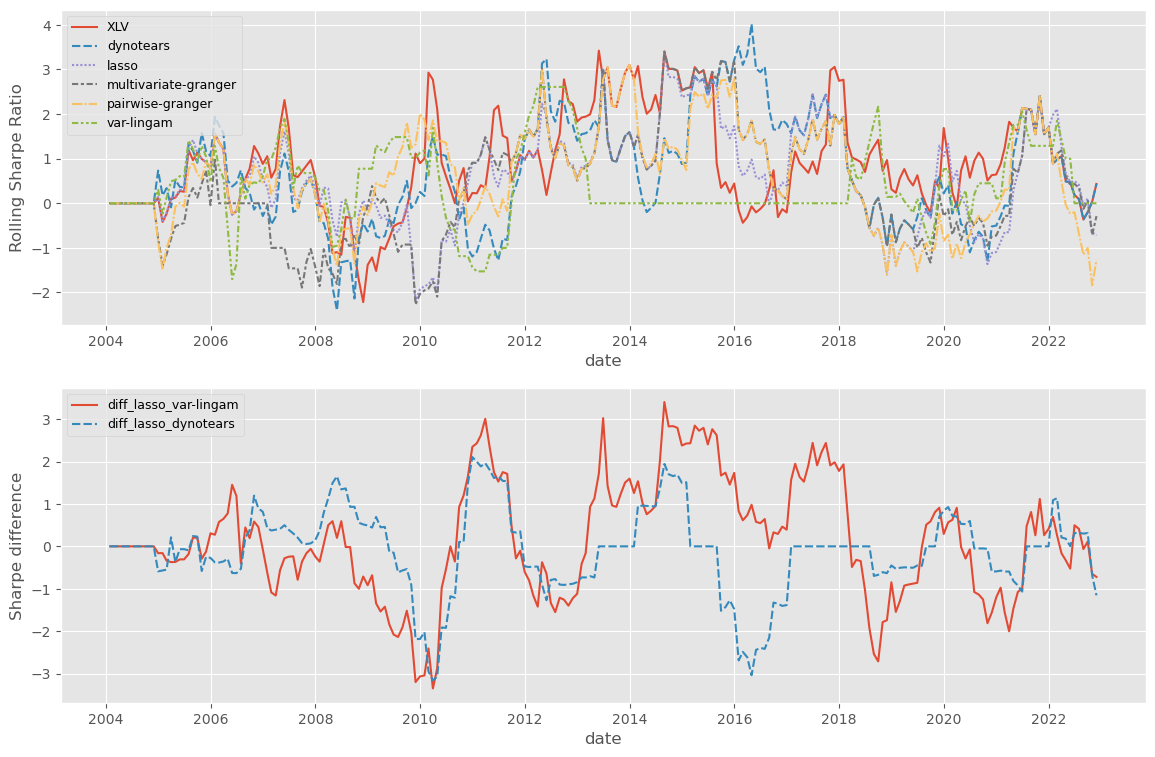

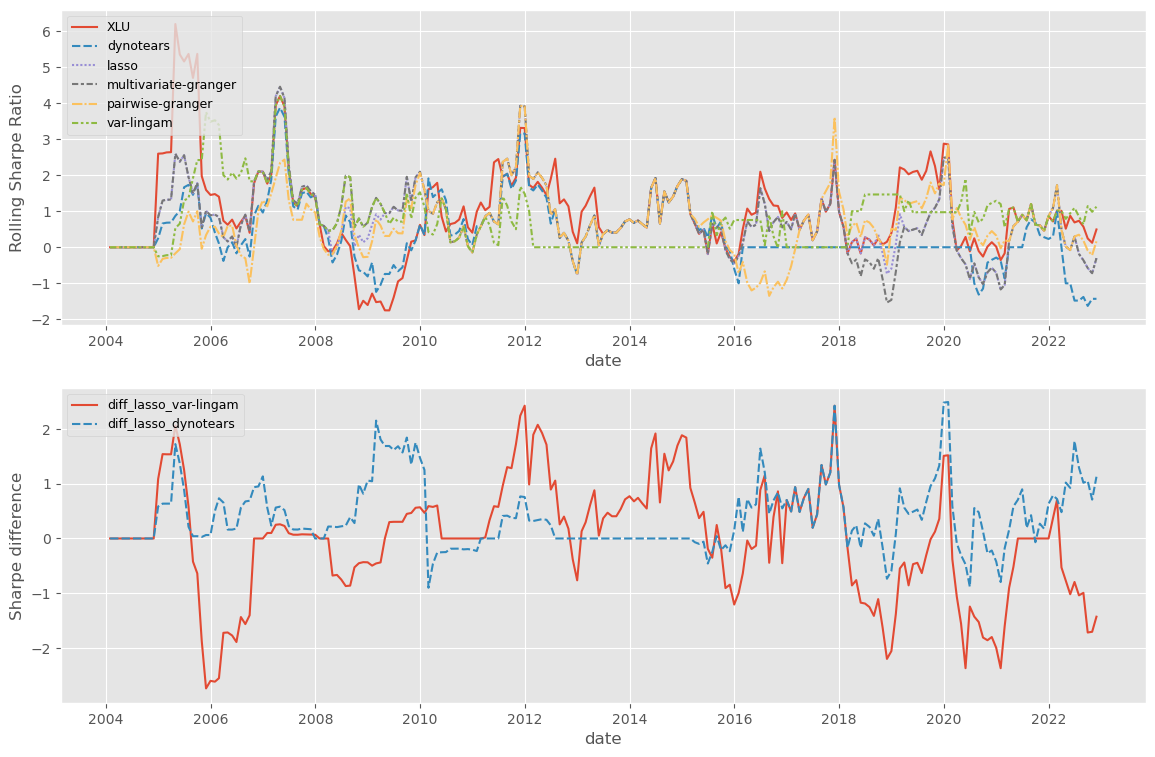

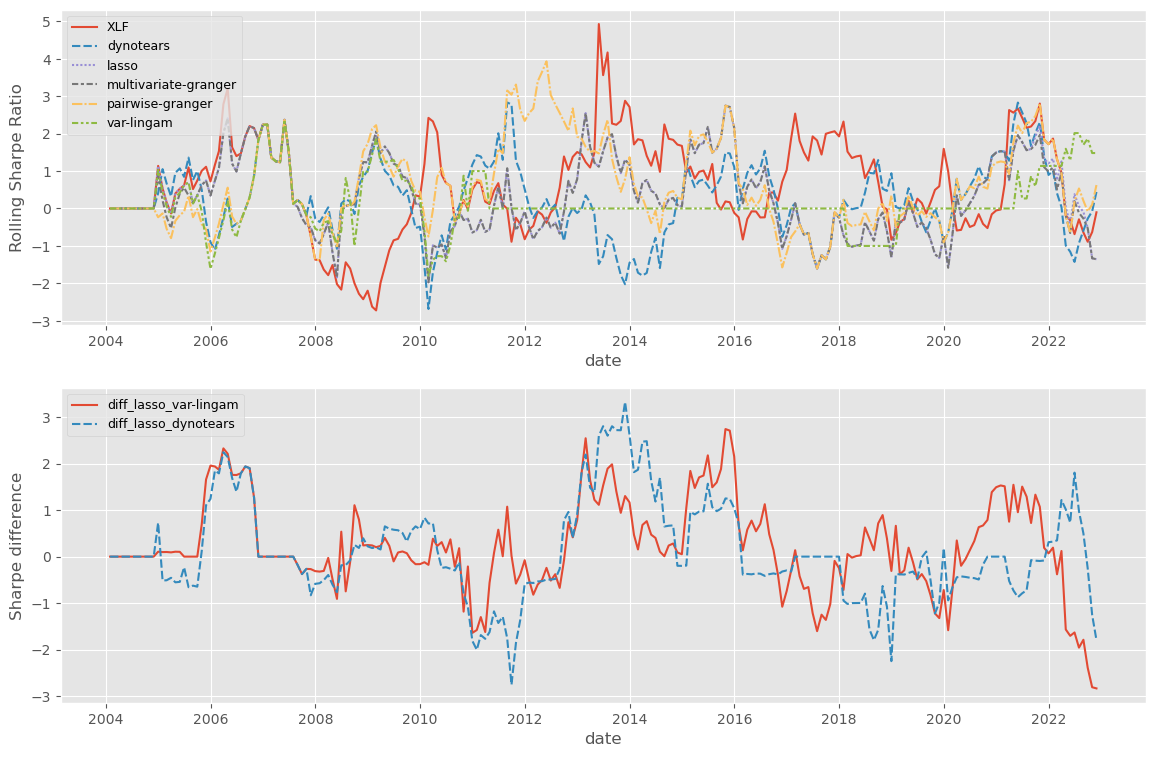

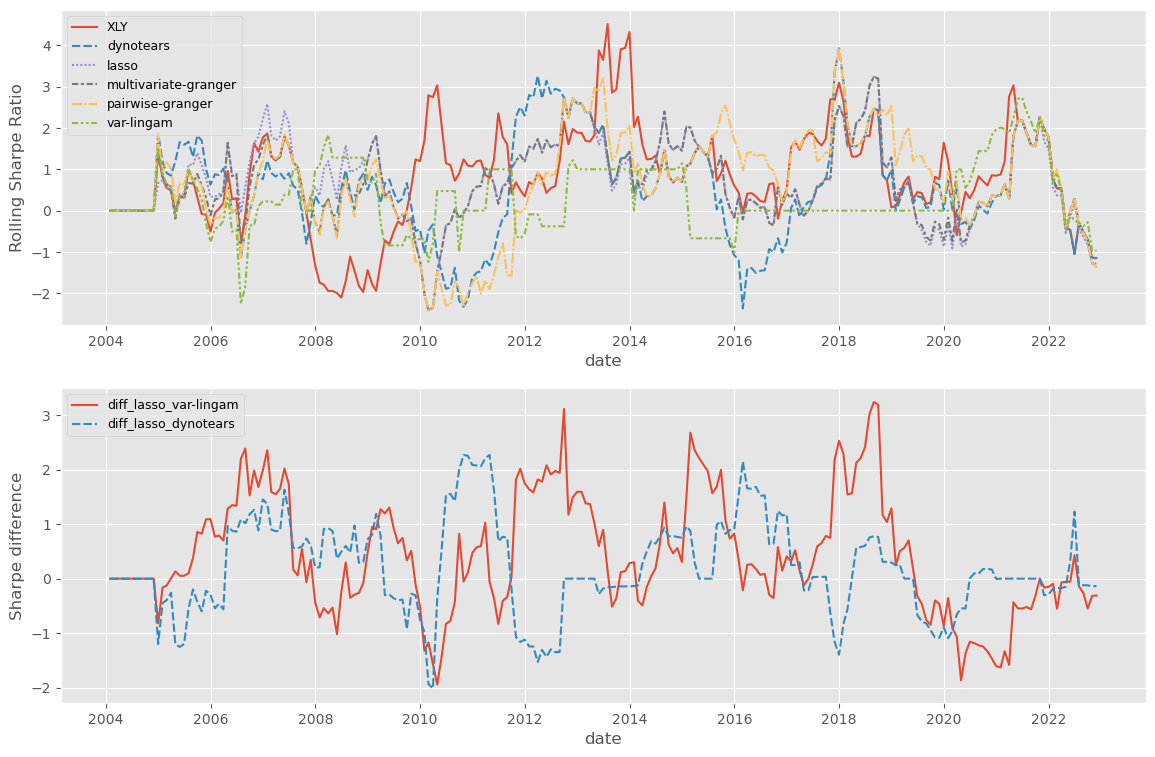

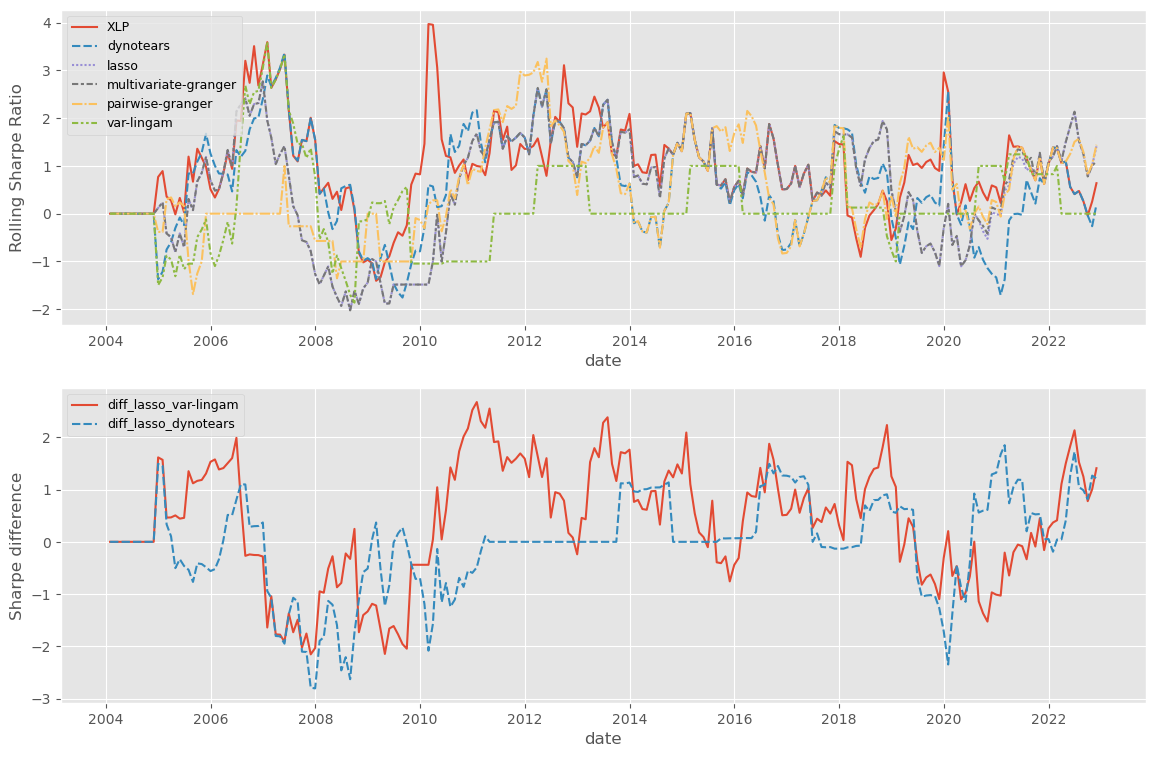

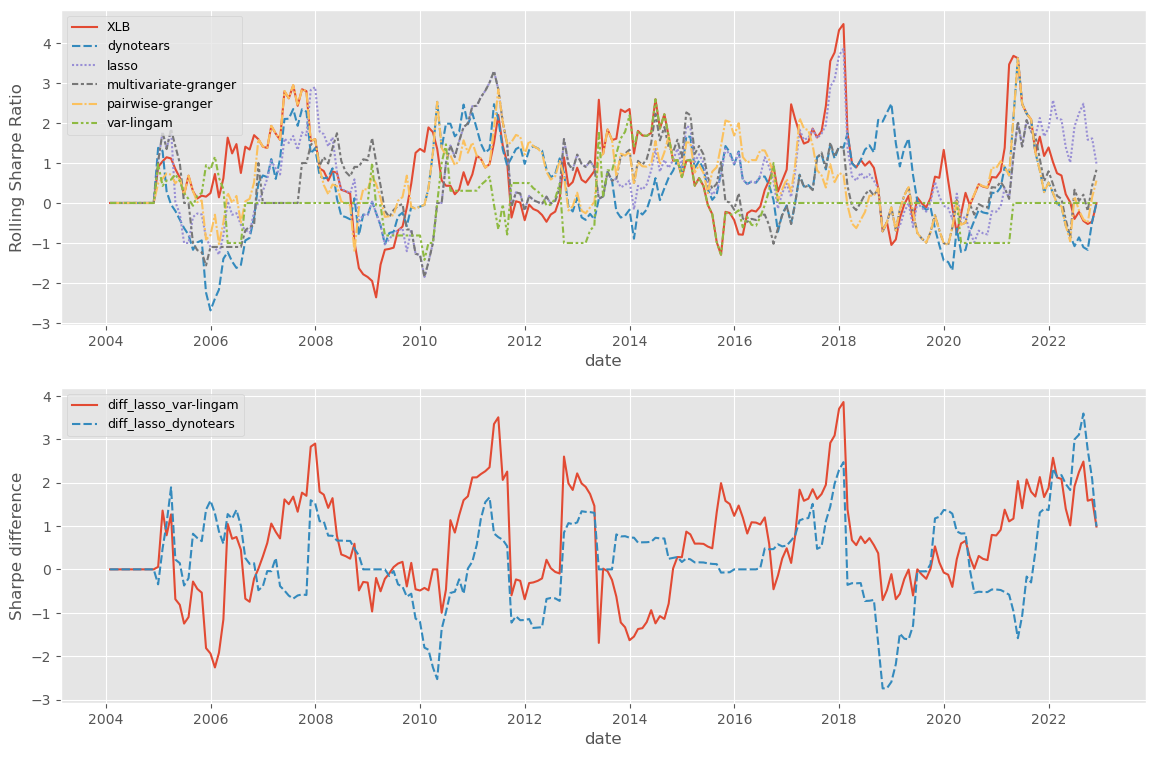

In [89]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    rolling_sharpe_df = tmp_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0).fillna(0)
    rolling_sharpe_diff_df = pd.DataFrame(rolling_sharpe_df["lasso"] - rolling_sharpe_df["var-lingam"], columns=["diff_lasso_var-lingam"])
    rolling_sharpe_diff_df["diff_lasso_dynotears"] = rolling_sharpe_df["lasso"] - rolling_sharpe_df["dynotears"]
    rolling_sharpe_diff_df = rolling_sharpe_diff_df.fillna(0)

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = rolling_sharpe_df, ax = ax[0])
    ax[0].set_ylabel("Rolling Sharpe Ratio")
    sns.lineplot(data = rolling_sharpe_diff_df, ax = ax[1])
    ax[1].set_ylabel("Sharpe difference")

    # set position of legend
    ax[0].legend(loc='upper left', prop={'size': 9})
    ax[1].legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_rolling_sharpe_fs.png"))

### Plot Cumulative Returns and Rolling Sharpe Ratios for Combined Portfolio

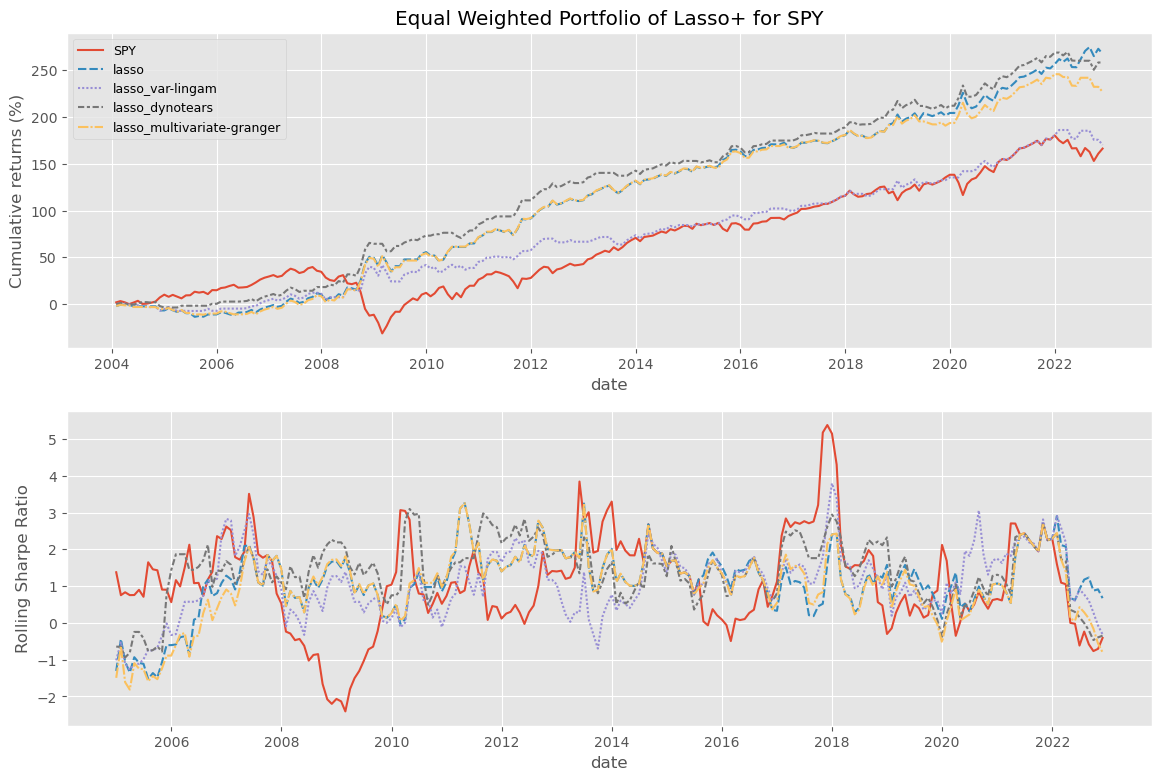

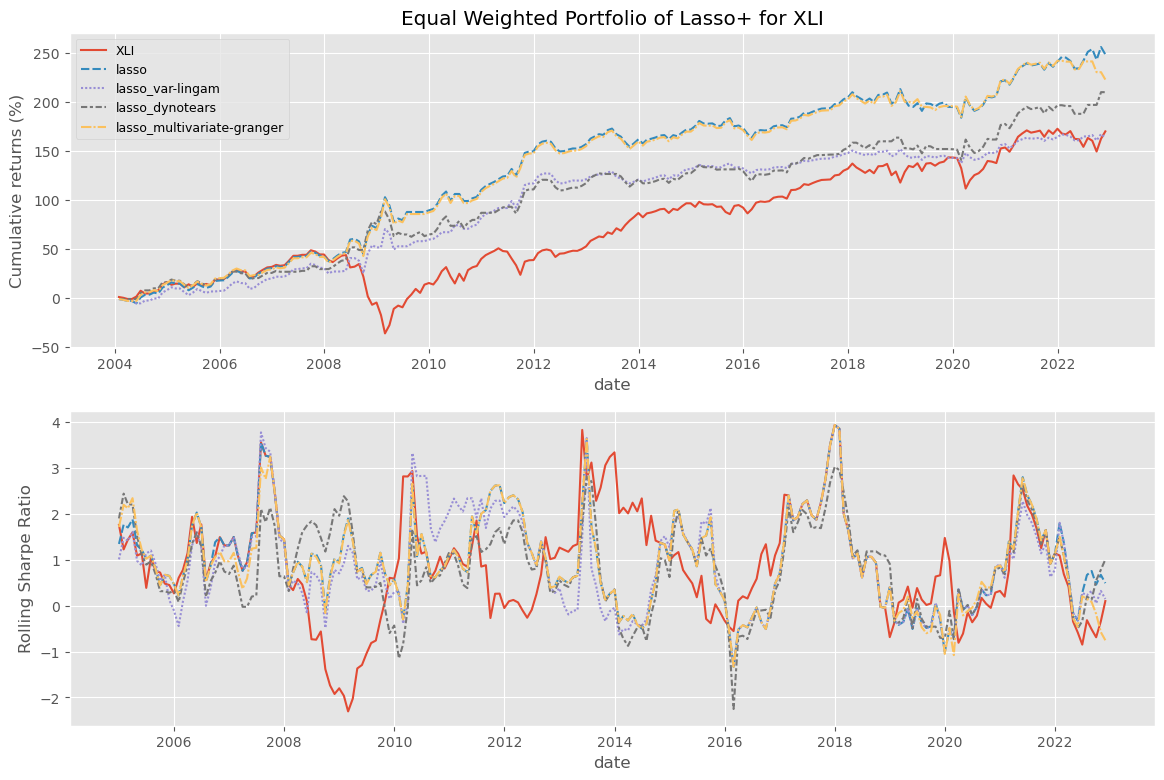

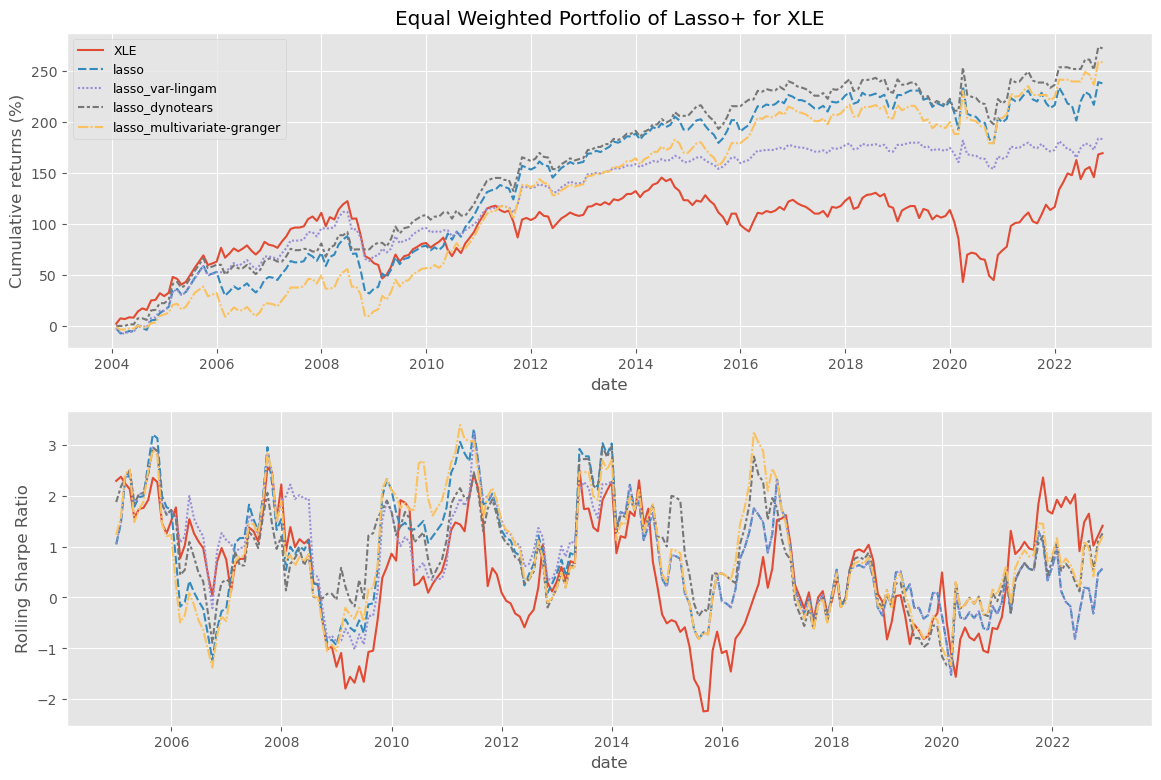

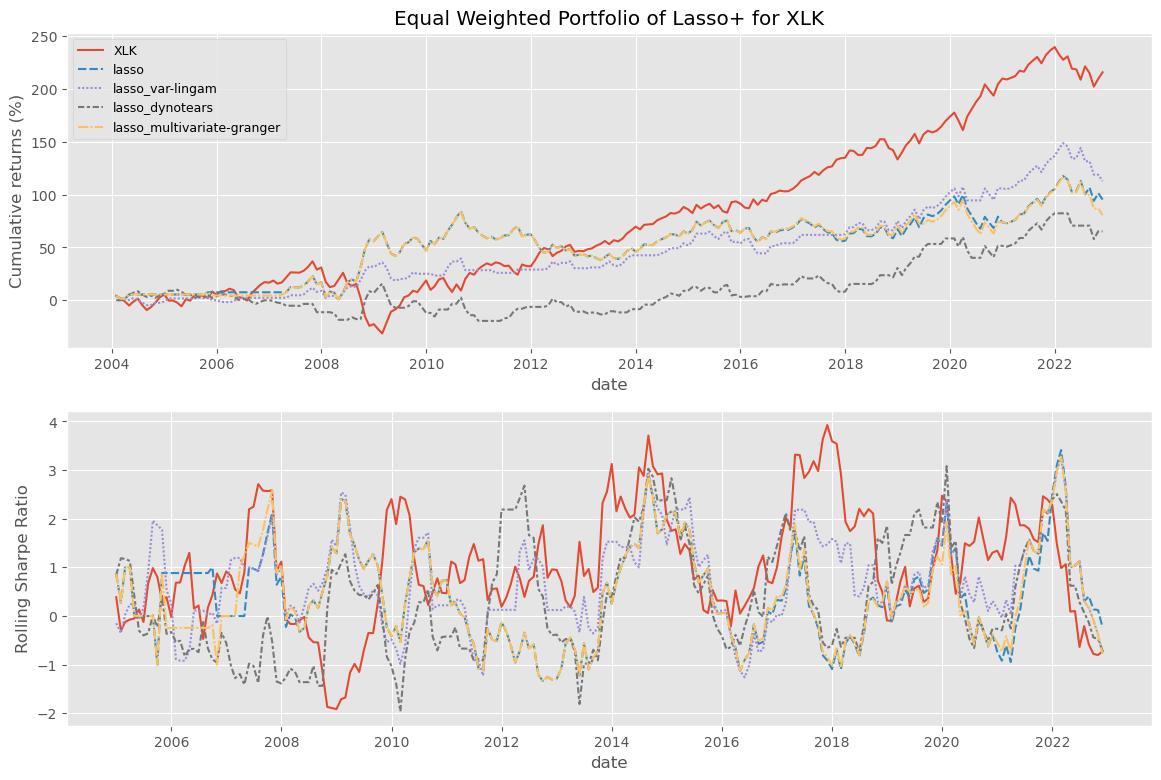

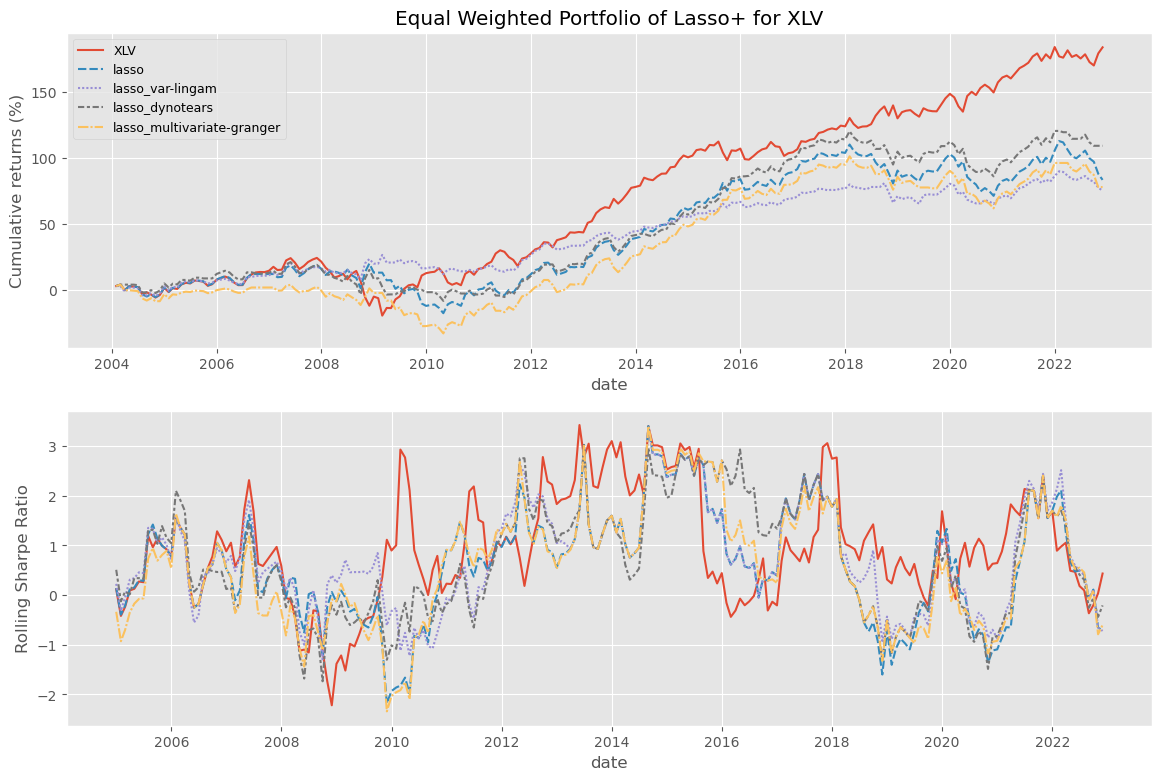

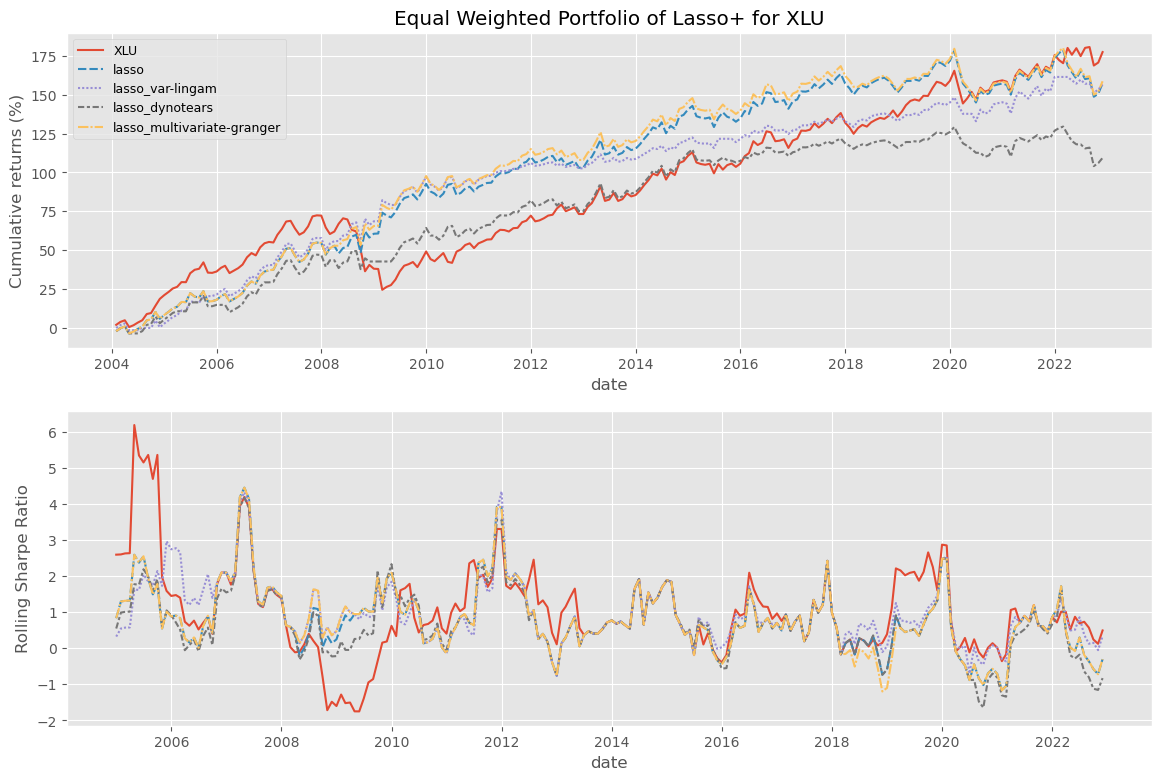

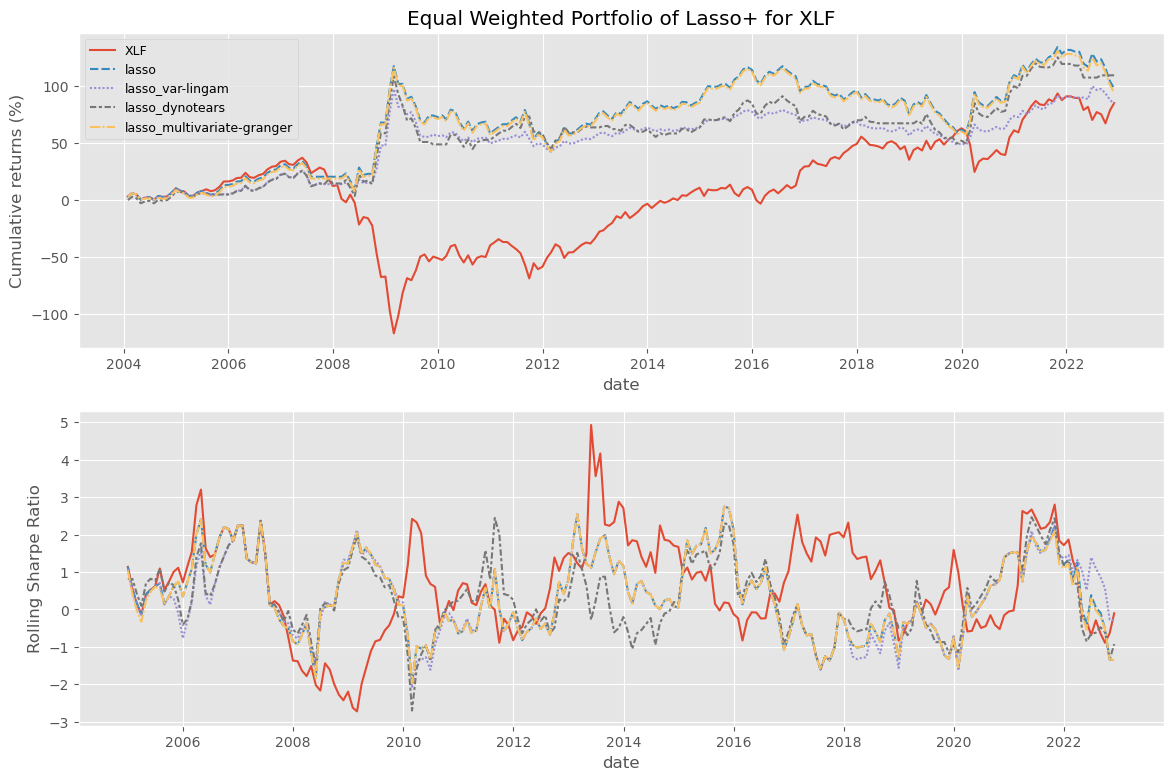

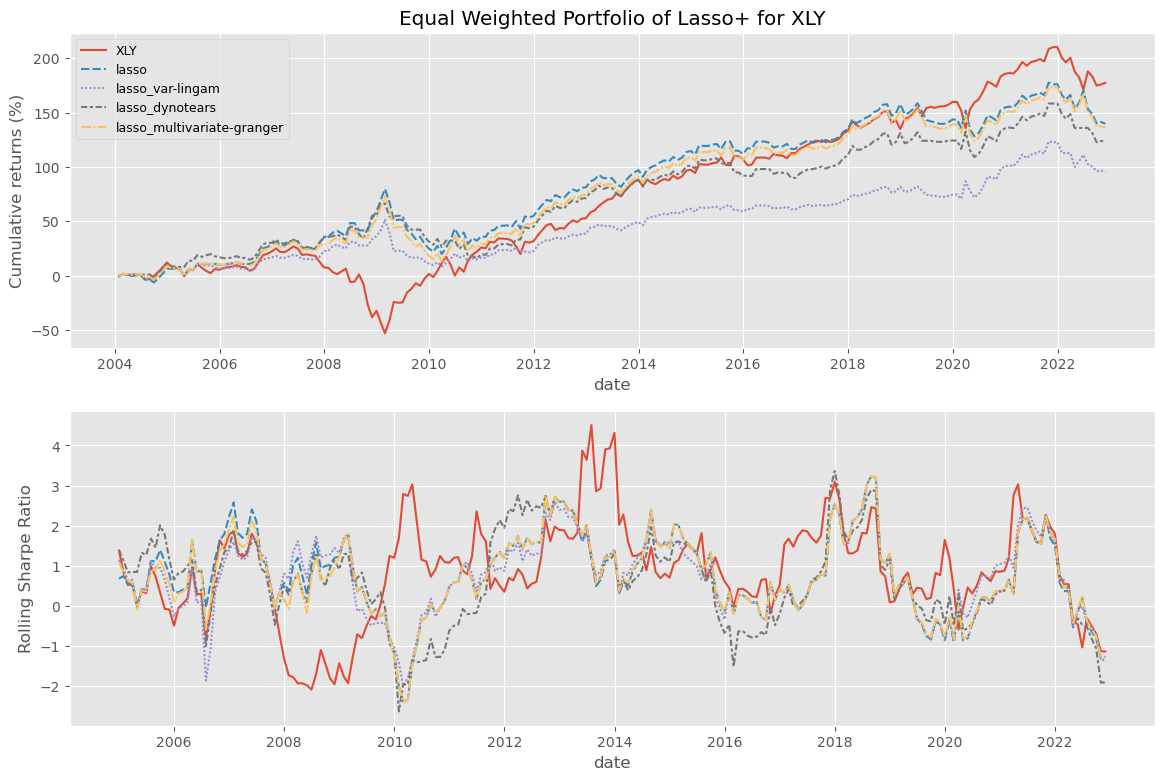

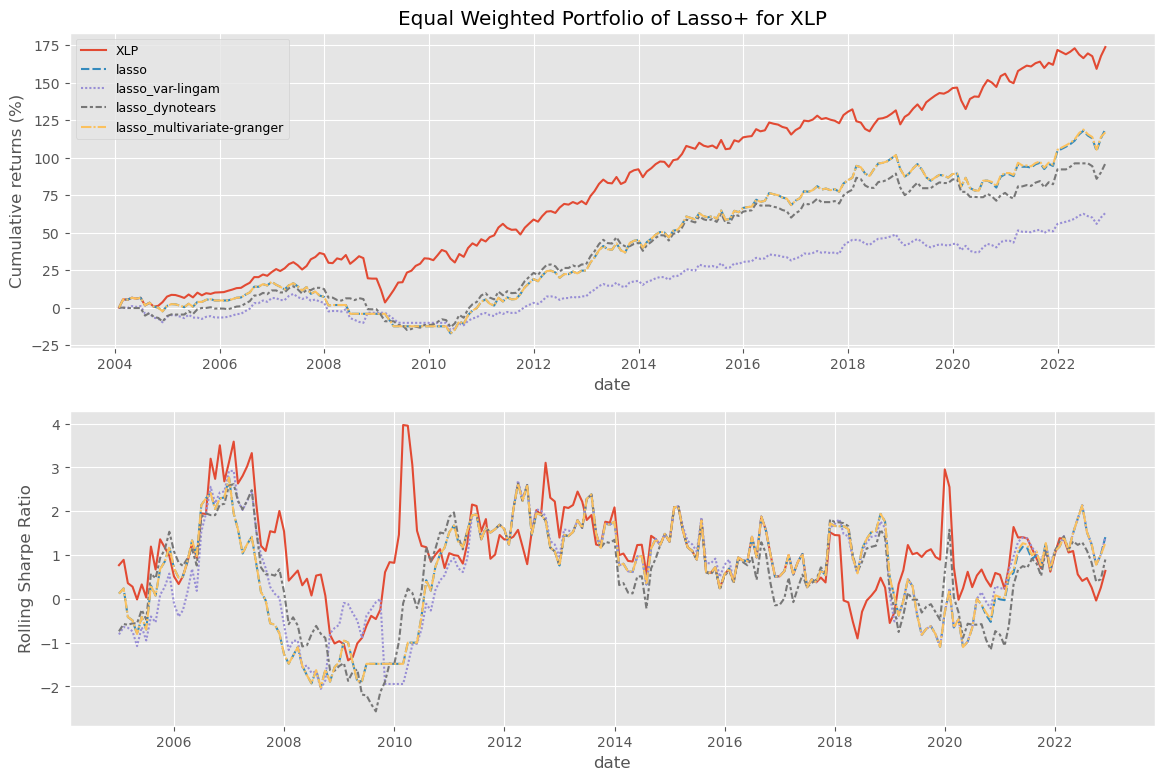

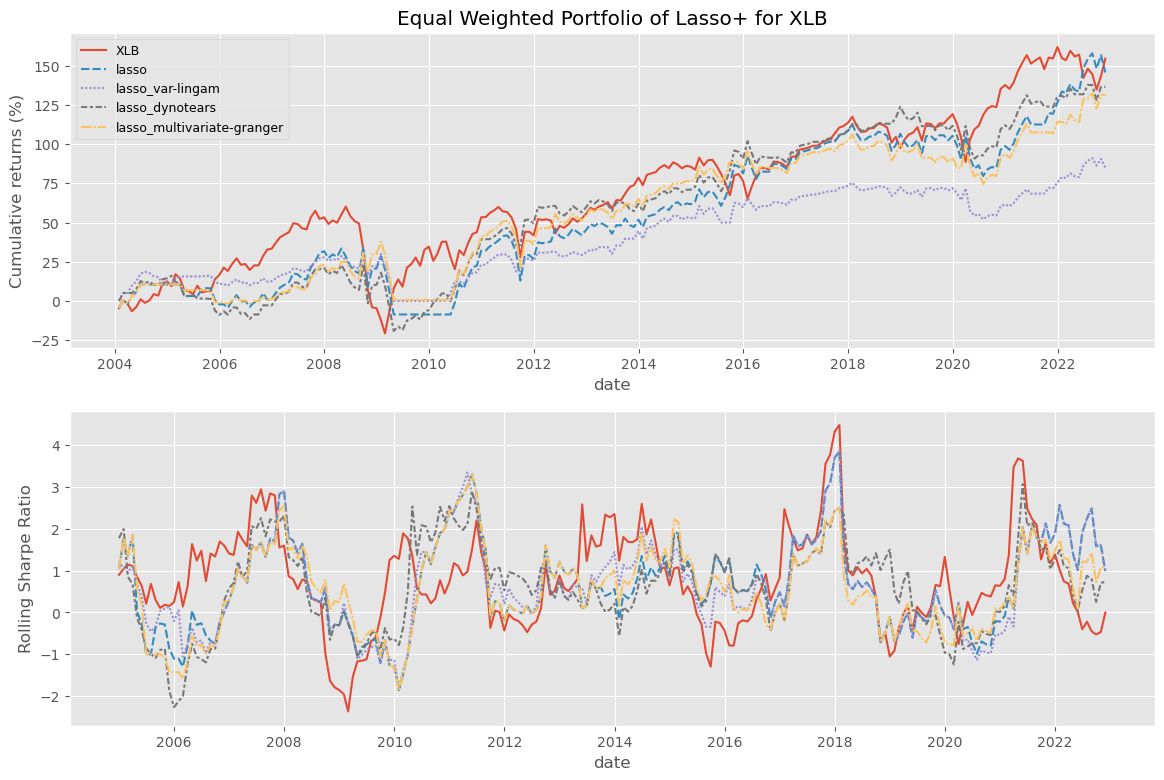

In [101]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["var-lingam"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["dynotears"]
    tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "lasso", "lasso_var-lingam", "lasso_dynotears", "lasso_multivariate-granger"]].copy()

    new_rolling_sharpe_df = new_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)    

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = new_dfPnl.cumsum() * 100, ax = ax[0])
    ax[0].set_ylabel("Cumulative returns (%)")
    ax[0].set_title(f"Equal Weighted Portfolio of Lasso+ for {target}")

    sns.lineplot(data = new_rolling_sharpe_df, ax = ax[1])
    ax[1].set_ylabel("Rolling Sharpe Ratio")

    ax[0].legend(loc='upper left', prop={'size': 9})
    # ax[1].legend(loc='upper left', prop={'size': 8})
    ax[1].get_legend().remove()

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret_combined.png"))

### Top Sharpe and MaxDD for the Combined Portfolios per ETF

In [91]:
all_measures = []
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["lasso_var-lingam"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["var-lingam"]
    tmp_dfPnl["lasso_dynotears"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["dynotears"]
    tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "lasso", "lasso_var-lingam", "lasso_dynotears", "lasso_multivariate-granger"]].copy()

    i = 0
    for tag, measure in metric_funcs.items():
        measure_values = measure(new_dfPnl)

        if i == 0:
            tmp_measure = pd.DataFrame(measure_values, columns=[tag])
        else:
            tmp_measure[tag] = measure_values
        i += 1
    
    tmp_measure["etf"] = target
    tmp_measure = tmp_measure.reset_index().set_index(["etf", "variable"])

    all_measures.append(tmp_measure)

all_measures_df = pd.concat(all_measures, axis=0)
melt_all_measures_df = all_measures_df.reset_index().rename(columns={"variable": "fs"}).melt(id_vars=["etf", "fs"])

In [92]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2)

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  \
etf variable                                                                
SPY lasso_dynotears             13.64       41.82    1.13     5.09  -1.79   
    lasso                       14.13       49.16    1.00     5.40  -2.72   
XLB lasso_dynotears              7.22       60.20    0.42     1.82  -7.55   
    lasso_multivariate-granger   6.94       58.50    0.41     1.81  -7.19   
XLE lasso_dynotears             14.39       81.08    0.61     3.10  -6.10   
    lasso_var-lingam             9.69       57.63    0.58     2.76  -5.86   
XLF lasso_var-lingam             4.48       51.80    0.30     1.80 -20.89   
    lasso_dynotears              5.79       68.69    0.29     1.64 -23.20   
XLI lasso                       13.13       62.54    0.73     3.76  -5.12   
    lasso_dynotears             11.09       54.40    0.71     3.43  -4.44   
XLK XLK                         11.40       61.70    0.64     3.15  -6.87   
    lasso_var-lingam             5.96       47.94    0.43     1.60  -5.23   
XLP XLP                          9.19       40.72    0.78     3.62  -2.90   
    lasso                        6.29       37.04    0.59     3.08  -7.06   
XLU lasso_var-lingam             8.28       37.57    0.76     3.83  -2.05   
    XLU                          9.38       49.03    0.66     2.85  -6.59   
XLV XLV                          9.73       47.43    0.71     3.55  -5.05   
    lasso_dynotears              5.78       41.73    0.48     2.46  -7.97   
XLY XLY                          9.38       63.36    0.51     2.37  -7.25   
    lasso                        7.39       60.90    0.42     1.84  -8.82   

                                MaxDD  
etf variable                           
SPY lasso_dynotears            -17.37  
    lasso                      -16.02  
XLB lasso_dynotears            -34.91  
    lasso_multivariate-granger -31.00  
XLE lasso_dynotears            -42.69  
    lasso_var-lingam           -38.18  
XLF lasso_var-lingam           -42.39  
    lasso_dynotears            -47.14  
XLI lasso                      -25.29  
    lasso_dynotears            -22.72  
XLK XLK                        -49.45  
    lasso_var-lingam           -30.26  
XLP XLP                        -28.13  
    lasso                      -29.16  
XLU lasso_var-lingam           -14.19  
    XLU                        -38.03  
XLV XLV                        -35.49  
    lasso_dynotears            -29.06  
XLY XLY                        -55.07  
    lasso                      -45.01

In [97]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &       &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & lasso\_dynotears &  13.64 &       41.82 &    1.13 &     5.09 &  -1.79 & -17.37 \\
    & lasso &  14.13 &       49.16 &    1.00 &     5.40 &  -2.72 & -16.02 \\
XLB & lasso\_dynotears &   7.22 &       60.20 &    0.42 &     1.82 &  -7.55 & -34.91 \\
    & lasso\_multivariate-granger &   6.94 &       58.50 &    0.41 &     1.81 &  -7.19 & -31.00 \\
XLE & lasso\_dynotears &  14.39 &       81.08 &    0.61 &     3.10 &  -6.10 & -42.69 \\
    & lasso\_var-lingam &   9.69 &       57.63 &    0.58 &     2.76 &  -5.86 & -38.18 \\
XLF & lasso\_var-lingam &   4.48 &       51.80 &    0.30 &     1.80 & -20.89 & -42.39 \\
    & lasso\_dynotears &   5.79 &       68.69 &    0.29 &     1.64 & -23.20 & -47.14 \\
XLI & lasso &  13.13 &       62.54 &    0.73 &     3.76 &  -5.12 & -25.29 \\
    & lasso\_dyn

In [98]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  \
etf variable                                                                
SPY lasso                       14.13       49.16    1.00     5.40  -2.72   
    lasso_var-lingam             8.99       39.96    0.78     3.48  -2.52   
XLB lasso_var-lingam             4.50       39.91    0.39     1.55  -5.40   
    lasso_multivariate-granger   6.94       58.50    0.41     1.81  -7.19   
XLE lasso_var-lingam             9.69       57.63    0.58     2.76  -5.86   
    lasso_multivariate-granger  13.68       84.35    0.56     2.69  -7.49   
XLF lasso_var-lingam             4.48       51.80    0.30     1.80 -20.89   
    lasso_dynotears              5.79       68.69    0.29     1.64 -23.20   
XLI lasso_var-lingam             8.64       45.61    0.66     3.17  -3.61   
    lasso_dynotears             11.09       54.40    0.71     3.43  -4.44   
XLK lasso_dynotears              3.45       47.75    0.25     1.04 -11.10   
    lasso_var-lingam             5.96       47.94    0.43     1.60  -5.23   
XLP lasso_var-lingam             3.34       22.93    0.50     2.58  -5.14   
    lasso_dynotears              5.08       33.79    0.52     2.48  -5.54   
XLU lasso_var-lingam             8.28       37.57    0.76     3.83  -2.05   
    lasso_dynotears              5.78       38.67    0.52     2.23  -3.99   
XLV lasso_var-lingam             3.97       30.41    0.45     2.29  -3.98   
    lasso_dynotears              5.78       41.73    0.48     2.46  -7.97   
XLY lasso_var-lingam             5.07       42.86    0.41     1.71  -7.62   
    lasso_dynotears              6.55       53.99    0.42     1.83  -8.28   

                                MaxDD  
etf variable                           
SPY lasso                      -16.02  
    lasso_var-lingam           -16.08  
XLB lasso_var-lingam           -25.90  
    lasso_multivariate-granger -31.00  
XLE lasso_var-lingam           -38.18  
    lasso_multivariate-granger -40.23  
XLF lasso_var-lingam           -42.39  
    lasso_dynotears            -47.14  
XLI lasso_var-lingam           -18.80  
    lasso_dynotears            -22.72  
XLK lasso_dynotears            -29.71  
    lasso_var-lingam           -30.26  
XLP lasso_var-lingam           -21.39  
    lasso_dynotears            -25.29  
XLU lasso_var-lingam           -14.19  
    lasso_dynotears            -22.44  
XLV lasso_var-lingam           -14.60  
    lasso_dynotears            -29.06  
XLY lasso_var-lingam           -34.92  
    lasso_dynotears            -39.73

In [99]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &                 &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & lasso &  14.13 &       49.16 &    1.00 &     5.40 &  -2.72 & -16.02 \\
    & lasso\_var-lingam &   8.99 &       39.96 &    0.78 &     3.48 &  -2.52 & -16.08 \\
XLB & lasso\_var-lingam &   4.50 &       39.91 &    0.39 &     1.55 &  -5.40 & -25.90 \\
    & lasso\_multivariate-granger &   6.94 &       58.50 &    0.41 &     1.81 &  -7.19 & -31.00 \\
XLE & lasso\_var-lingam &   9.69 &       57.63 &    0.58 &     2.76 &  -5.86 & -38.18 \\
    & lasso\_multivariate-granger &  13.68 &       84.35 &    0.56 &     2.69 &  -7.49 & -40.23 \\
XLF & lasso\_var-lingam &   4.48 &       51.80 &    0.30 &     1.80 & -20.89 & -42.39 \\
    & lasso\_dynotears &   5.79 &       68.69 &    0.29 &     1.64 & -23.20 & -47.14 \\
XLI & lasso\_var-lingam &   8.64 &       45.61 &    0.66 &     3.17 & 